**In this script, the calculated clusters will be qualitatively interpreted to gain an understanding of each of the types of actors**

# Imports and Data Loading

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import networkx as nx

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.impute import SimpleImputer

In [3]:
full_data = pd.read_csv('../results/author_full_features_and_clusters.csv')

In [4]:
features = full_data.drop(columns=['author', 'avg_flesch_reading_ease_class', 'cluster_0_prob', 'cluster_1_prob', 'cluster_2_prob', 'cluster_3_prob', 'cluster_4_prob', 'cluster_5_prob'])

# Visualizing Node Embedidngs

In [5]:
# load embeddings from npy files
embeddings = np.load('../results/author_full_embeddings.npy')

In [6]:
# fit tsne
tsne = TSNE(n_components=2, random_state=42)

tsne_4 = tsne.fit_transform(embeddings)

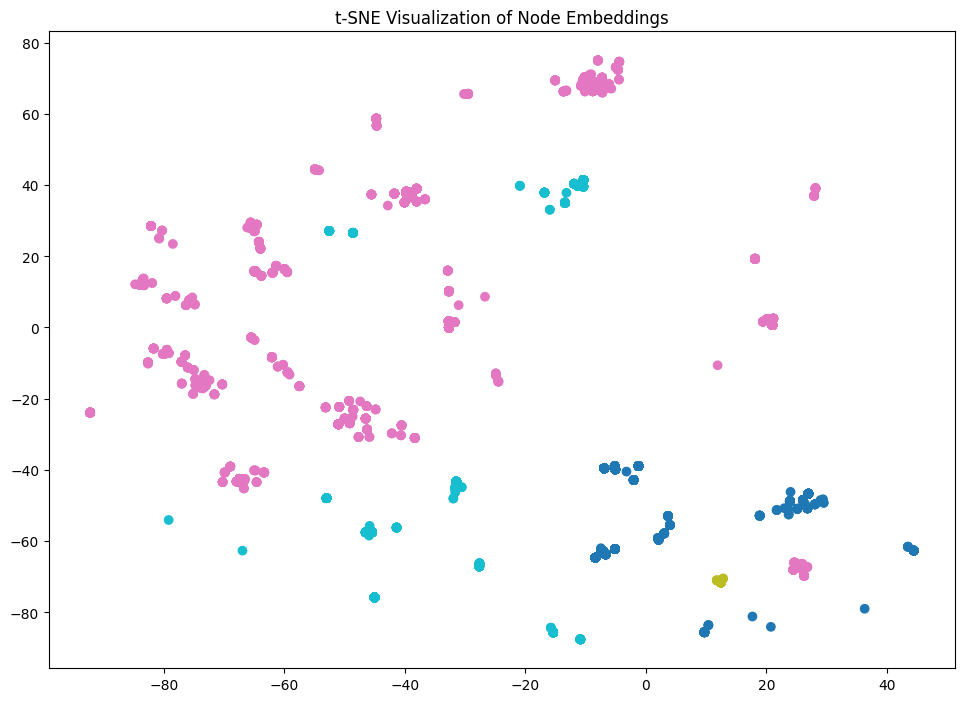

In [22]:
# plot t-SNE embeddings
plt.figure(figsize=(11.69, 8.27))
plt.scatter(tsne_4[:, 0], tsne_4[:, 1], c=full_data['cluster'], cmap='tab10')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()

# ANOVA - Clusters

In [38]:
# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

In [39]:
# ANOVA for each feature
anova_results = {}
for feature in features_imputed.columns[:-1]:  # Exclude the cluster column
    groups = [features_imputed[feature][features_imputed['cluster'] == cluster] for cluster in features_imputed['cluster'].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[feature] = {'F-value': f_val, 'p-value': p_val}

In [40]:
anova_features = pd.DataFrame(anova_results).T
print(anova_features)

                          F-value   p-value
noun_count               0.215154  0.885949
verb_count               0.395304  0.756387
adj_count                0.569148  0.635288
positive_sentiment       3.771646  0.010155
negative_sentiment       0.665503  0.573144
neutral_sentiment        1.973529  0.115582
channel_messages         0.267819  0.848639
group_messages           0.267819  0.848639
sent_count               0.177156  0.911924
word_count               0.335903  0.799387
avg_sent_length          1.088229  0.352619
avg_word_length          0.661309  0.575762
exclamation_count        1.280577  0.279106
question_count           1.052837  0.367855
emoji_count              1.928084  0.122636
flesch_reading_ease      1.060558  0.364484
liwc_I                   0.977847  0.402012
liwc_We                  1.199182  0.308364
liwc_You                 1.586545  0.190311
liwc_Other               0.932443  0.423964
liwc_Affect              1.054023  0.367336
own_message              1.10229

In [41]:
# get significant diffs between clusters
significant_features = {}
for feature in features_imputed.columns[:-1]:  # Exclude the cluster column
    tukey = pairwise_tukeyhsd(endog=features_imputed[feature], groups=features_imputed['cluster'], alpha=0.05)
    significant_pairs = tukey.summary().data[1:]
    significant_clusters = [pair for pair in significant_pairs if pair[-1] == True]
    if significant_clusters:
        significant_features[feature] = significant_clusters

In [42]:
# Print significant features for each cluster
for feature, clusters in significant_features.items():
    print(f"Feature: {feature}")
    for cluster in clusters:
        print(f"  Significant difference between clusters: {cluster[0]} and {cluster[1]}")

Feature: positive_sentiment
  Significant difference between clusters: 0.0 and 3.0
  Significant difference between clusters: 0.0 and 5.0


In [43]:
# get mean of eaxh feature oe each cluster
features.groupby('cluster').mean()

,noun_count,verb_count,adj_count,positive_sentiment,negative_sentiment,neutral_sentiment,channel_messages,group_messages,sent_count,word_count,avg_sent_length,avg_word_length,exclamation_count,question_count,emoji_count,flesch_reading_ease,liwc_I,liwc_We,liwc_You,liwc_Other,liwc_Affect,own_message,forwarded_message,total_message_count,was_forwarded,own_message_count,forwarded_message_count,action_quotient,sentiment_quotient,toxicity
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47.826058,32.497649,9.507052,0.224123,0.365931,0.338289,0.000000,1.000000,2.430994,18.289211,5.560361,4.460404,0.215306,0.193946,0.447635,71.892904,0.022210,0.005637,0.010887,0.022716,0.060486,0.790640,0.117353,19.590074,0.014706,13.878676,3.790441,3.617356,0.443266,0.124415
3,50.904810,32.210513,10.201499,0.198148,0.368583,0.362421,0.000505,0.999495,2.436130,17.656669,5.488466,4.515913,0.216822,0.199870,0.422473,71.357384,0.021802,0.005284,0.010325,0.022404,0.059968,0.779825,0.120012,22.077045,0.074021,14.294571,4.465598,3.622989,0.420388,0.122859
4,48.250000,33.843750,8.468750,0.174001,0.423296,0.337444,0.000000,1.000000,2.125973,13.988962,4.890329,4.860964,0.323303,0.159464,0.381659,67.549332,0.014363,0.008163,0.006253,0.015034,0.089798,0.787853,0.131288,39.294118,0.000000,18.676471,14.794118,3.284581,0.435828,0.144867
5,59.623589,37.984763,12.810384,0.193439,0.378250,0.359757,0.000564,0.999436,2.435228,17.709397,5.823512,4.506913,0.192281,0.220915,0.366053,71.795662,0.020388,0.006040,0.011669,0.023494,0.059974,0.769676,0.119855,23.445058,0.073758,14.173106,4.821375,3.721857,0.435626,0.123719


# Network Metrics

In [20]:
adj = np.load('../results/author_full_adj.npy')

In [23]:
G = nx.from_numpy_array(adj)

In [36]:
# get basic information about graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = int(np.mean(list(dict(G.degree()).values())))
min_degree = np.min(list(dict(G.degree()).values()))
max_degree = np.max(list(dict(G.degree()).values()))

In [ ]:
print('Total Number of Nodes:', num_nodes)
print('Total Number of Edges:', num_edges)
print('Average Degree:', avg_degree)
print('Minimum Degree:', min_degree)
print('Maximum Degree:', max_degree)

Total Number of Nodes: 16885
Total Number of Edges: 60965422
Average Degree: 7221
Minimum Degree: 0
Maximum Degree: 16821
